In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))

import numpy as np
import torch as th
import torch.nn.functional as F

from motornet.policy import ModularPolicyGRU

from IPython.display import clear_output
import matplotlib.pyplot as plt
from typing import Any

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

%load_ext autoreload
%autoreload 2

import motornet as mn

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

device = th.device("cpu")
#th.set_default_device(device)

import torch._dynamo.config
torch._dynamo.config.cache_size_limit = 128 


saveLoc = '/Users/mahdiyar/Desktop/jon'

All packages imported.
pytorch version: 2.1.0
numpy version: 1.26.0
motornet version: 0.2.0


In [17]:
# class ExpTask:
#     def __init__(self, effector, **kwargs):
#         self.effector = effector
#         self.dt = self.effector.dt
#         self.pre_range = kwargs.get('pre_range', [0.3, 0.3])
#         self.c1_range = kwargs.get('c1_range', [0.6, 1.0])
#         self.c2_range = kwargs.get('c2_range', [0.6, 1.0])
#         self.c3_range = kwargs.get('c3_range', [0.8, 1.6])
#         self.target_size = kwargs.get('target_size', 0.0)
#         self.background_load = kwargs.get('background_load', 0.)
#         self.run_mode = kwargs.get('run_mode', 'train')
#         self.delay_range = [5000, 5000]  # this has to exist to get the size of the inputs

#     def generate(self, batch_size, n_timesteps, **kwargs):
#         goal_states = self.effector.joint2cartesian(self.effector.draw_random_uniform_states(batch_size=batch_size)).to("cpu").numpy()
#         targets = np.tile(np.expand_dims(goal_states, axis=1), (1, n_timesteps, 1))
#         inputs = np.zeros(shape=(batch_size, n_timesteps,2 + 2 + 1 + 1 + 1))
#         perturbations = np.zeros(shape=(batch_size, n_timesteps, 2))
#         pre_range = self.pre_range
#         c1_range = self.c1_range
#         c2_range = self.c2_range
#         c3_range = self.c3_range

#         if self.run_mode == 'train_grow':
#             go_chance = 0.25
#             catch_chance = 0.5

#         init_states = self.effector.draw_random_uniform_states(batch_size).detach().cpu().numpy() #base_joint_rand
#         background_loads = np.tile([0, self.background_load], [batch_size, 1]) + np.random.uniform(low=-0., high=0., size=(batch_size, 2))
            
#         for i in range(batch_size):
#             center_joint = init_states[i, :].astype(np.float32)
#             center = self.effector.joint2cartesian(th.tensor(center_joint)).to("cpu").numpy()


#             c1_time = generate_delay_time(pre_range[0] / self.dt, pre_range[1] / self.dt, 'random')
#             c2_time = c1_time + generate_delay_time(c1_range[0] / self.dt, c1_range[1] / self.dt, 'random')
#             pert_time = c2_time + generate_delay_time(c2_range[0] / self.dt, c2_range[1] / self.dt, 'random')
#             c3_time = pert_time + generate_delay_time(c3_range[0] / self.dt, c3_range[1] / self.dt, 'random')

#             # cue order not randomized
#             targ_time = c1_time
#             back_time = c3_time
#             # is this a catch trial?
#             if np.greater_equal(np.random.rand(), catch_chance):
#                 is_catch = False
#             else:
#                 is_catch = True
#                 pert_time = inputs.shape[1]
        
#             if np.greater_equal(np.random.rand(), go_chance):
#                 is_gocue = False
#             else:
#                 is_gocue = True

#             # Targets
#             targets[i, :, :] = np.tile(np.expand_dims(self.effector.joint2cartesian(self.effector.draw_random_uniform_states(1)).detach().cpu().numpy(), axis=1),[1, n_timesteps, 1])

#             # where we're going
#             inputs[i, targ_time:back_time, 0:2] = targets[i, targ_time, 0:2]
#             inputs[i, back_time:, 0:2] = center[:, 0:2]
#             # where we come from
#             inputs[i, :, 2:4] = center[:, 0:2]

#             perturbation = np.repeat(np.expand_dims(background_loads[i, :], axis=0), n_timesteps, axis=0)  # background load
#             if not is_catch:
#                 targets[i, 0:pert_time, :] = center
#                 targets[i, back_time:, :] = center

#                 if is_gocue:
#                     inputs[i, pert_time:, 4] = 1.
#                 else:
#                     perturbation[pert_time:back_time, :] = background_loads[i, :] + np.random.uniform(low=-1, high=1, size=2)
#             else:
#                 targets[i, :, :] = center
  
#             inputs[i, :, :] = inputs[i, :, :] + np.random.normal(loc=0., scale=1e-3,size=(inputs.shape[1], inputs.shape[2]))
            
#             # shift inputs by visual delay
#             inputs[i, 10:, :-1] = inputs[i, 0:-10, :-1]
            
#             perturbations[i, :, :] = perturbation

#         all_inputs = {"inputs": inputs, "joint_load": perturbations}
#         return [all_inputs, targets, init_states]

# def generate_delay_time(delay_min, delay_max, delay_mode):
#     if delay_mode == 'random':
#         delay_time = np.random.uniform(delay_min, delay_max)
#     elif delay_mode == 'noDelayInput':
#         delay_time = 0
#     else:
#         raise AttributeError

#     return int(delay_time)

In [2]:
class ExpTask:
    def __init__(self, effector, **kwargs):
        self.effector = effector
        self.dt = self.effector.dt
        self.pre_range = kwargs.get('pre_range', [0.1, 0.3])
        self.run_mode = kwargs.get('run_mode', 'train')

    def generate(self, batch_size, n_timesteps, **kwargs):
        goal_states = self.effector.joint2cartesian(self.effector.draw_random_uniform_states(batch_size=batch_size)).to("cpu").numpy()
        targets = np.tile(np.expand_dims(goal_states, axis=1), (1, n_timesteps, 1))
        inputs = np.zeros(shape=(batch_size, n_timesteps,2 + 2 + 1)) # 2D target, 2D initial, 1D go cue

        pre_range = self.pre_range

        catch_chance = 0.5

        init_states = self.effector.draw_random_uniform_states(batch_size).detach().cpu().numpy()

            
        for i in range(batch_size):
            center_joint = init_states[i, :].astype(np.float32)
            center = self.effector.joint2cartesian(th.tensor(center_joint)).to("cpu").numpy()


            c1_time = generate_delay_time(pre_range[0] / self.dt, pre_range[1] / self.dt, 'random') # go cue

            # is this a catch trial?
            if np.greater_equal(np.random.rand(), catch_chance):
                is_catch = False
            else:
                is_catch = True

            # Targets
            targets[i, :, :] = np.tile(np.expand_dims(self.effector.joint2cartesian(self.effector.draw_random_uniform_states(1)).detach().cpu().numpy(), axis=1),[1, n_timesteps, 1])

            # where we're going
            inputs[i, :, 0:2] = targets[i, 0, 0:2]

            # where we come from
            inputs[i, :, 2:4] = center[:, 0:2]

            if not is_catch:
                targets[i, 0:c1_time, :] = center
                inputs[i, c1_time:, 4] = 1.
            else:
                targets[i, :, :] = center
  
            inputs[i, :, :] = inputs[i, :, :] + np.random.normal(loc=0., scale=1e-3,size=(inputs.shape[1], inputs.shape[2]))
            
            # shift inputs by visual delay
            inputs[i, 10:, :-1] = inputs[i, 0:-10, :-1]
            
        all_inputs = {"inputs": inputs}
        return [all_inputs, targets, init_states]

def generate_delay_time(delay_min, delay_max, delay_mode):
    if delay_mode == 'random':
        delay_time = np.random.uniform(delay_min, delay_max)
    elif delay_mode == 'noDelayInput':
        delay_time = 0
    else:
        raise AttributeError

    return int(delay_time)

In [10]:
from task_jm import ExpTaskEnv


dt = 0.01
ep_dur = 1

mm = mn.muscle.RigidTendonHillMuscle()
ee = mn.effector.RigidTendonArm26(muscle=mm, timestep=dt)
env = ExpTaskEnv(max_ep_duration=ep_dur, effector=ee,
                     proprioception_delay=0.01, vision_delay=0.07,
                     proprioception_noise=1e-3, vision_noise=1e-3, action_noise=1e-4)

env.to(device)
print("Task subclass built.\n")

obs, info = env.reset()

print("obs shape:          ", obs.shape, end="\n\n\n")

for key, val in info.items():
  if type(val) is dict:
    print(key + ": ")
    for k, v in val.items():
      print("\t\t\t" + k + " shape:" + " " * (10-len(k)), v.shape)
  else:
    print(key + " shape:" + " " * (13-len(key)), val.shape)

Task subclass built.

obs shape:           torch.Size([1, 14])


states: 
			joint shape:      torch.Size([1, 4])
			cartesian shape:  torch.Size([1, 4])
			muscle shape:     torch.Size([1, 7, 6])
			geometry shape:   torch.Size([1, 4, 6])
			fingertip shape:  torch.Size([1, 2])
action shape:        torch.Size([1, 6])
noisy action shape:  torch.Size([1, 6])


In [11]:
n_t = int(ep_dur / env.effector.dt)
params = {'pre_range': [0.1, 0.3],'run_mode': 'train_grow'}
task = ExpTask(effector=env.effector, **params)

inputs, targets, init_states = task.generate(1, n_t)

In [12]:
# PFC, PMd, M1, S1, PPC, Spinal
proportion_excitatory = None#[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
vision_mask = [0, 0, 0, 0, 1, 0]
proprio_mask = [0, 0, 0, 0, 0, 1]
task_mask = [0, 0, 0, 0, 1, 0]
c1 = 0.2
c2 = 0.05
c3 = 0.01
c0 = 0.5
connectivity_mask = np.array([[c0, c1, c3, 0, c1, 0],
                              [c1, c0, c1, c3, c1, 0],
                              [c2, c1, c0, c1, c3, c3],
                              [0, 0, c3, c0, c3, c1],
                              [c1, c1, c3, c1, c0, 0],
                              [0, 0, c1, 0, 0, c1]])
connectivity_mask[connectivity_mask > 1] = 1
connectivity_delay = np.zeros_like(connectivity_mask)
output_mask = [0, 0, 0, 0, 0, 1]
module_sizes = [64, 64, 64, 64, 64, 16]
spectral_scaling = 1.
# input sparsity
vision_dim = np.arange(env.get_vision().shape[1])
proprio_dim = np.arange(env.get_proprioception().shape[1]) + vision_dim[-1] + 1
task_dim = np.arange(inputs['inputs'].shape[2]) + proprio_dim[-1] + 1
policy = ModularPolicyGRU(env.observation_space.shape[0] + inputs['inputs'].shape[2], module_sizes, env.n_muscles, 
                vision_dim=vision_dim, proprio_dim=proprio_dim, task_dim=task_dim, 
                vision_mask=vision_mask, proprio_mask=proprio_mask, task_mask=task_mask,
                connectivity_mask=connectivity_mask, output_mask=output_mask, connectivity_delay=connectivity_delay,
                proportion_excitatory=proportion_excitatory, input_gain=1,
                spectral_scaling=spectral_scaling, device=device, activation='tanh')
optimizer = th.optim.Adam(policy.parameters(), lr=3e-3)
scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9999)

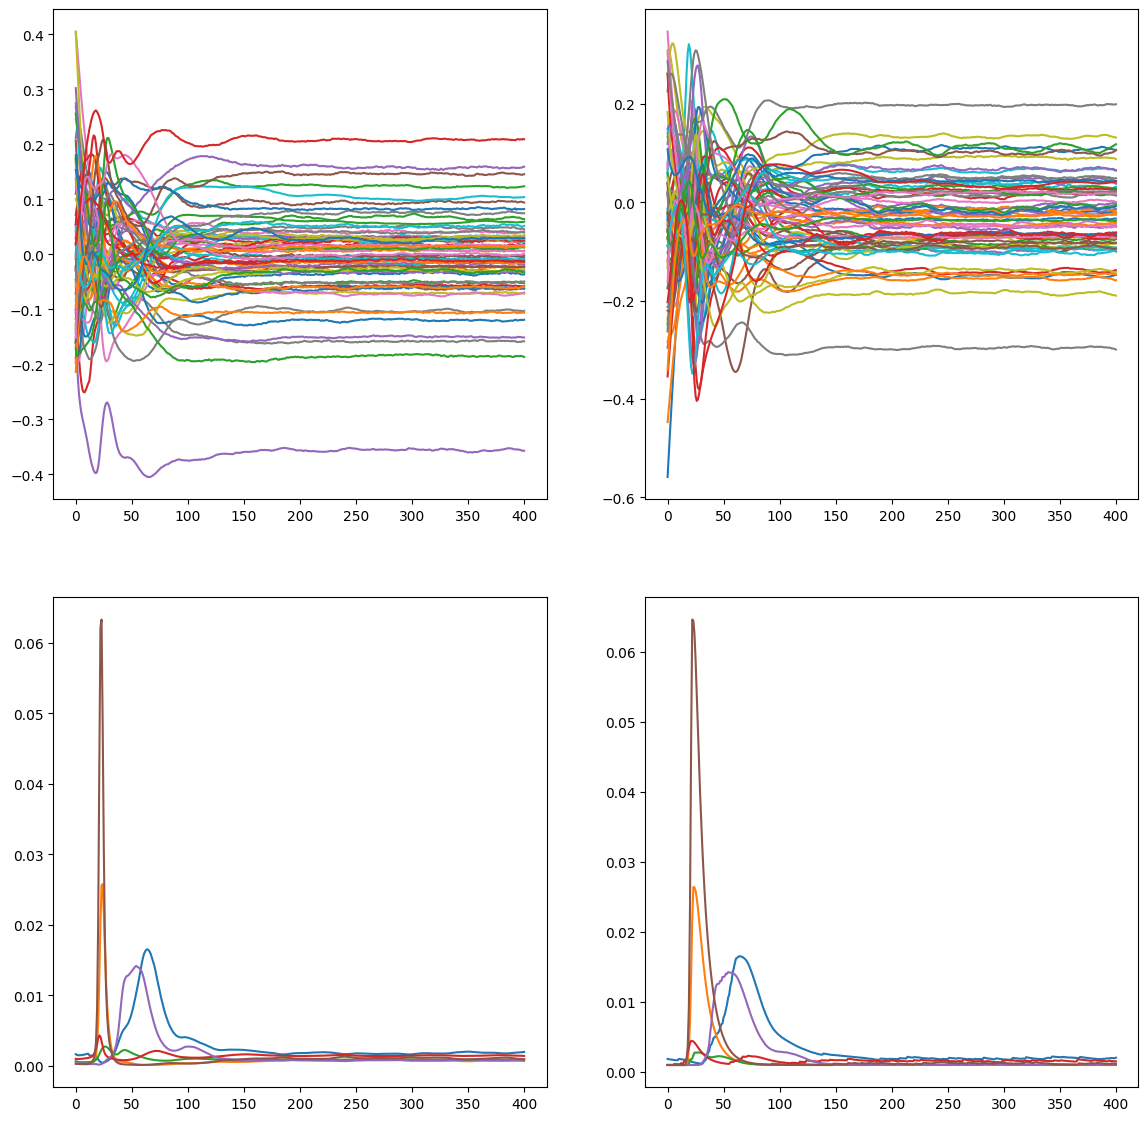

Cartesian:2.7915 Muscle:1.415756583 jerk:0.0165 Activity:0.11373
Batch 550/10000 Done, total policy loss: 4.6747
[0.0017447044764831077]
Cartesian:2.9109 Muscle:1.531040311 jerk:0.0013 Activity:0.12056
Batch 551/10000 Done, total policy loss: 4.8922
[0.0017445300060354595]
Cartesian:3.1306 Muscle:1.561661124 jerk:0.0038 Activity:0.12428
Batch 552/10000 Done, total policy loss: 5.1645
[0.001744355553034856]
Cartesian:1.8876 Muscle:1.143020034 jerk:0.0171 Activity:0.13948
Batch 553/10000 Done, total policy loss: 3.4649
[0.0017441811174795524]
Cartesian:1.4665 Muscle:1.028814316 jerk:0.0231 Activity:0.14590
Batch 554/10000 Done, total policy loss: 2.9197
[0.0017440066993678045]
Cartesian:2.4376 Muscle:1.349906325 jerk:0.0012 Activity:0.13655
Batch 555/10000 Done, total policy loss: 4.2140
[0.0017438322986978677]
Cartesian:3.0302 Muscle:1.442399502 jerk:0.0016 Activity:0.13197
Batch 556/10000 Done, total policy loss: 4.9142
[0.0017436579154679979]
Cartesian:3.0904 Muscle:1.422281623 jerk:0

In [16]:
batch_size = 32
n_batch = 10000
losses = []
interval = 50

task.run_mode = 'train_grow'


for batch in range(n_batch):
  ep_dur = np.random.uniform(low=4., high=4.)
  env.max_ep_duration = ep_dur
  n_t = int(ep_dur / env.effector.dt) + 1

  inputs, targets, init_states = task.generate(batch_size, n_t)
  targets = th.tensor(targets[:,:,0:2], device=device, dtype=th.float)
  inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
  init_states = th.tensor(init_states, device=device, dtype=th.float)

  # initialize batch
  h = policy.init_hidden(batch_size)
  obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
  terminated = False

  # initial positions and targets
  xy = []
  all_actions = []
  all_muscle = []
  all_hidden = []
  all_force = []
  all_targets = []
  all_inp = []

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(env.elapsed / env.dt)
    
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
        
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info['states']['cartesian'][:, None, :])  # trajectories
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_force.append(info['states']['muscle'][:,-1,None,:])
    all_hidden.append(h[:,None,:])
    all_targets.append(th.unsqueeze(targets[:,t_step,:], dim=1))
    all_inp.append(th.unsqueeze(inp[:,t_step,:], dim=1))
    
  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  all_hidden = th.cat(all_hidden, axis=1)
  all_actions = th.cat(all_actions, axis=1)
  all_muscle = th.cat(all_muscle, axis=1)
  all_force = th.cat(all_force, axis=1)
  all_targets = th.cat(all_targets, axis=1)
  all_inp = th.cat(all_inp, axis=1)


  # compute loss
  cartesian_loss = 1e2 * th.mean(th.sum(th.abs(xy[:,:,0:2] - all_targets), dim=-1)) # 1e2 best
  muscle_loss = 1e-1 * th.mean(th.sum(all_force, dim=-1)) # 1e-1 best
  activity_loss = 1e-2 * th.mean(th.sum(th.square(all_hidden), dim=-1)) # 1e-2 best
  jerk_loss = 1e-6 * th.mean(th.sum(th.square(th.diff(xy[:,:,2:], 2, 1) / th.square(th.tensor(env.effector.dt))), dim=-1)) # 1e-6 best
  actjerk_loss = 2e-10 * th.mean(th.sum(th.square(th.diff(all_hidden, 3, 1) / th.pow(th.tensor(env.effector.dt), 3)), dim=-1))

  loss = cartesian_loss + muscle_loss + jerk_loss + activity_loss + actjerk_loss
  
  # backward pass & update weights
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())
  scheduler.step()
  optimizer.zero_grad()

  
  #policy.enforce_dale(zero_out=True)
  print(scheduler.get_last_lr())

  if (batch % interval == 0):
      clear_output(wait=True)
      fg, ax = plt.subplots(nrows=2,ncols=2)
      fg.set_figwidth(14)
      fg.set_figheight(14)

      ind = 0
      ax[0,0].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[4]])))
      ax[0,1].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[1]])))
      ax[1,0].plot(np.squeeze(all_actions.detach().cpu().numpy()[ind,:,:]))
      ax[1,1].plot(np.squeeze(all_muscle.detach().cpu().numpy()[ind,:,:]))
     
      #mn.plotor.plot_pos_over_time(xy[:,:,0:2].cpu().detach(), ax[5])
      plt.show()
      th.save(policy.state_dict(), saveLoc + 'weights')
  print("Cartesian:{:.4f} Muscle:{:.9f} jerk:{:.4f} Activity:{:.5f}".format(cartesian_loss.detach().cpu(), muscle_loss.detach().cpu(), jerk_loss.detach().cpu(), activity_loss.detach().cpu()))
  print("Batch {}/{} Done, total policy loss: {:.4f}".format(batch, n_batch, losses[-1]))

In [ ]:
task.run_mode = 'experiment'
batch_size = 2000
ep_dur = 3.
env.max_ep_duration = ep_dur
n_t = int(ep_dur / env.effector.dt) + 1
inputs, targets, init_states = task.generate(batch_size, n_t)
targets = th.tensor(targets[:,:,0:2], device=device, dtype=th.float)
inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
loads = th.tensor(inputs['joint_load'], device=device, dtype=th.float)
init_states = th.tensor(init_states, device=device, dtype=th.float)
# initialize batch
h = policy.init_hidden(batch_size)
obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
terminated = False

# initial positions and targets
xy = []
all_actions = []
all_muscle = []
all_hidden = []
all_joint = []
all_vision = []
all_proprio = []

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(env.elapsed / env.dt)
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action, **{'joint_load': loads[:,t_step,:]})
    xy.append(info['states']['cartesian'][:, None, :])  # trajectories
    all_joint.append(info['states']['joint'][:, None, :])  # trajectories
    all_vision.append(obs[:, None, vision_dim])
    all_proprio.append(obs[:, None, proprio_dim])
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_hidden.append(h[:,None,:])

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.cat(xy, axis=1)
all_hidden = th.cat(all_hidden, axis=1)
all_actions = th.cat(all_actions, axis=1)
all_muscle = th.cat(all_muscle, axis=1)
all_proprio = th.cat(all_proprio, axis=1)
all_vision = th.cat(all_vision, axis=1)
all_joint = th.cat(all_joint, axis=1)

In [ ]:
import scipy.io
toSave = {'joint': all_joint.detach().numpy(),
                          'cartesian': xy.detach().numpy(),
                          'muscle': all_muscle.detach().numpy(),
                          'inputs': inputs["inputs"],
                          'targets': targets.detach().numpy(),
                          'joint_load': inputs["joint_load"],
                          'neural': all_hidden.detach().numpy(),
                          'proprio': all_proprio.detach().numpy(),
                          'visual': all_vision.detach().numpy(),
                          'module_dims': policy.module_dims,
                          'Wz': policy.Wz.detach().numpy(),
          'Wr': policy.Wr.detach().numpy(),
          'Wh': policy.Wh.detach().numpy(),
          'Y': policy.Y.detach().numpy(),
          'losses': losses
          }
scipy.io.savemat(saveLoc + 'results.mat', toSave)
th.save(policy.state_dict(), saveLoc + 'weights')

In [ ]:
inputs['inputs'].shape
ii = 0
fg, ax = plt.subplots(nrows=3,ncols=1)
ax[0].plot(inputs['inputs'][ii,:,:])
ax[1].plot(inputs['joint_load'][ii,:,:])
ax[2].plot(targets[ii,:,:])

In [ ]:
ii = 3
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(np.concatenate((targets.detach().cpu().numpy()[ii,:,:], xy.detach().cpu().numpy()[ii,:,0:2]), axis=1))

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  #axs.semilogy(log)
  axs.plot(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

In [ ]:
ii = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(all_muscle.detach().cpu().numpy()[ii,:,:])
ax[1].plot(all_muscle.detach().cpu().numpy()[ii+1,:,:])

In [ ]:
ii = 0
m = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
h = np.squeeze(all_hidden.detach().cpu().numpy()[ii : ii+2,:,policy.module_dims[m]])
ax[0].plot(h[0,:,:])
ax[1].plot(h[1,:,:])
print(h.shape)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(policy.mask_Wr.detach().cpu().numpy(), aspect='equal', interpolation='none', cmap=plt.cm.Greys)
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
Wh = policy.Wh.detach().cpu().numpy()[:,task_dim[-1]+1:]
plt.imshow(Wh, aspect='equal', interpolation='none', cmap=plt.cm.spring)
plt.show()
plt.figure(figsize=(6,4))
E = th.linalg.eigvals(th.Tensor(Wh)).detach().numpy()
plt.scatter(np.real(E), np.imag(E))
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
Wr = policy.Wr.detach().cpu().numpy()
plt.imshow(Wr, aspect='equal', interpolation='none')
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(policy.Wz.detach().cpu().numpy(), aspect='equal', interpolation='none')
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(policy.Y.detach().cpu().numpy(), aspect='auto', interpolation='none')
plt.show()

In [ ]:
th._dynamo.list_backends()